##  Deep Neural Networks Project

In this project, you will be working with a real-world data set from the Las Vegas Metropolitan Police Department. The dataset  contains information about the reported incidents, including the time and location of the crime, type of incident, and number of persons involved.

The dataset is downloaded from the public docket at:
https://opendata-lvmpd.hub.arcgis.com

let's read the csv file and transform the data:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
orig_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PR/LVMPD-Stats.csv', parse_dates=['ReportedOn'])

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PR/LVMPD-Stats.csv', parse_dates=['ReportedOn'],
                 usecols = ['X', 'Y', 'ReportedOn',
                            'Area_Command','NIBRSOffenseCode',
                            'VictimCount' ] )

df['DayOfWeek'] = df['ReportedOn'].dt.day_name()
df['Time' ]     = df['ReportedOn'].dt.hour
df.drop(columns = 'ReportedOn', inplace=True)

In [5]:
df['X'] = df['X']
df['Y'] = df['Y']
df['Time'] = pd.factorize(df['Time'])[0]
df['DayOfWeek'] = pd.factorize(df['DayOfWeek'])[0]
df.Area_Command = pd.factorize(df['Area_Command'])[0]
df.VictimCount = pd.factorize(df['VictimCount'])[0]
df.NIBRSOffenseCode = pd.factorize(df['NIBRSOffenseCode'])[0]
df.dropna(inplace=True)

In [6]:
df= df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode',
       'DayOfWeek', 'Time','VictimCount']]

In [7]:
df.values.shape

(275, 7)

# Goal
The goal is to build a predictive model that is trained on the following data:
* latitude and longitude (location)
* Hour of the day
* Day of the week
* Area-of-command code: The police designation of the bureau of the operation.
* Classification code for the crime committed
  
The predicted variable is the number of persons involved in the accident.


## Task 1
* print a few rows of the values in the dataframe ``df`` and explain what each column of data means.

In [8]:
print(df.head())

            X          Y  Area_Command  NIBRSOffenseCode  DayOfWeek  Time  \
0 -115.087518  36.216702             0                 0          0     0   
1 -115.240172  36.189693             1                 1          1     1   
2 -115.143088  36.181329             2                 1          2     0   
3 -115.225014  36.117633             3                 1          1     2   
4 -115.176708  36.095967             4                 1          1     3   

   VictimCount  
0            0  
1            0  
2            1  
3            2  
4            0  


**X**: Latitude - This column contains the latitude coordinates of the incident's location.

**Y**: Longitude - This column holds the longitude coordinates of the incident's location.

**Area_Command**: Area-of-command code - This column contains codes that indicate the police bureau responsible for the operation in that area.

**NIBRSOffenseCode**: Classification code for the crime committed - This column contains codes that categorize the type of crime committed in the incident.

**DayOfWeek**: Weekday - This column indicates the specific day of the week when the incident was reported.

**Time**: Hour of Reporting - This column displays the hour of the day when the incident was reported.

**VictimCount**: Count of Individuals - This serves as the target variable, representing the number of people involved in the incident.

* identify the input and target variables

**Input Variables**:
1. X
2. Y
3. Area_Command
4. NIBRSOffenseCode
5. DayOfWeek
6. Time



**Target Variable**:


* VictimCount


* what is the range of values in each column? Do you need to scale, shift or normalize your data?

The need to scale, shift, or normalize our data depends on our analysis goals and the machine learning algorithms we plan to use. Scaling can help when features have different ranges. Shifting changes the mean of the data, while normalization makes the data follow a specific distribution. The decision depends on our specific context and the requirements of our analysis. Experimentation may be necessary to determine the most suitable approach.

In [9]:
print(df.describe())

                X           Y  Area_Command  NIBRSOffenseCode   DayOfWeek  \
count  275.000000  275.000000    275.000000        275.000000  275.000000   
mean  -115.159326   36.143360      3.978182          0.909091    2.981818   
std      0.101294    0.118418      3.045799          0.334878    1.924590   
min   -116.000000   35.068419      0.000000          0.000000    0.000000   
25%   -115.209198   36.114704      1.000000          1.000000    1.000000   
50%   -115.149945   36.152415      3.000000          1.000000    3.000000   
75%   -115.105200   36.183854      6.000000          1.000000    5.000000   
max   -114.625570   37.000000     11.000000          2.000000    6.000000   

             Time  VictimCount  
count  275.000000   275.000000  
mean    11.236364     0.712727  
std      7.039937     0.978427  
min      0.000000     0.000000  
25%      5.000000     0.000000  
50%     11.000000     0.000000  
75%     18.000000     1.000000  
max     23.000000     6.000000  


**X**: Ranges from -116.0 to -114.625570.

**Y**: Ranges from 35.068419 to 37.0.

**Area_Command**: Ranges from 0 to 11.

**NIBRSOffenseCode**: Ranges from 0 to 2.

**DayOfWeek**: Ranges from 0 to 6.

**Time**: Ranges from 0 to 23.

**VictimCount**: Ranges from 0 to 6.

## Task 2

* Create two `DataLoader` objects for training and testing based on the input and output variables. Pick a reasonable batch size and verify the shape of data by iterating over the one dataset and printing the shape of the batched data.

In [10]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import numpy as np

# Load the data
orig_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PR/LVMPD-Stats.csv', parse_dates=['ReportedOn'])

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PR/LVMPD-Stats.csv', parse_dates=['ReportedOn'],
                 usecols=['X', 'Y', 'ReportedOn', 'Area_Command', 'NIBRSOffenseCode', 'VictimCount'])

df['DayOfWeek'] = df['ReportedOn'].dt.day_name()
df['Time'] = df['ReportedOn'].dt.hour
df.drop(columns='ReportedOn', inplace=True)
df['X'] = df['X']
df['Y'] = df['Y']
df['Time'] = pd.factorize(df['Time'])[0]
df['DayOfWeek'] = pd.factorize(df['DayOfWeek'])[0]
df.Area_Command = pd.factorize(df['Area_Command'])[0]
df.VictimCount = pd.factorize(df['VictimCount'])[0]
df.NIBRSOffenseCode = pd.factorize(df['NIBRSOffenseCode'])[0]
df.dropna(inplace=True)

df = df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode', 'DayOfWeek', 'Time', 'VictimCount']]

class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data.iloc[idx].values
        input_data = sample[:-1]
        target = sample[-1]
        return input_data, target

dataset = CustomDataset(df)
batch_size = 32

# Split the dataset into training and testing sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create DataLoader objects for training and testing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Verify the shape of data by iterating over one dataset
for inputs, targets in train_loader:
    print("Training Batch Input Shape:", inputs.shape)
    print("Training Batch Target Shape:", targets.shape)
    break

for inputs, targets in test_loader:
    print("Testing Batch Input Shape:", inputs.shape)
    print("Testing Batch Target Shape:", targets.shape)
    break


Training Batch Input Shape: torch.Size([32, 6])
Training Batch Target Shape: torch.Size([32])
Testing Batch Input Shape: torch.Size([32, 6])
Testing Batch Target Shape: torch.Size([32])


## Task 3
In this task you will try to predict number of crime victims as a **real number**. Therefore the machine learning problem is a **regression** problem.

* Define the proper loss function for this task

We need to choose a way to measure how good our predictions are. For predicting numbers, we can use something called Mean Squared Error. It helps us see how far off our predictions are from the actual numbers.

In [11]:
criterion = torch.nn.MSELoss()

* what should the size of the predicted output be?

Since we're predicting one number (the number of crime victims), our prediction will be just one number.

In [12]:
import torch

class RegressionModel(torch.nn.Module):
    def __init__(self, input_size):
        super(RegressionModel, self).__init__()
        self.fc = torch.nn.Linear(input_size, 1)  # Output size is 1 for regression

    def forward(self, x):
        x = self.fc(x)
        return x

# Example usage:
input_size = 6
model = RegressionModel(input_size)

* explain your choice of architecture, including how many layers you will be using

We can use a basic neural network where all the neurons are connected. We have the flexibility to experiment with different layer sizes, the number of layers, and various activation functions to see what gives us the best results.

In [13]:
import torch

class RegressionModel(torch.nn.Module):
    def __init__(self, input_size):
        super(RegressionModel, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, 64)  # First hidden layer with 64 neurons
        self.fc2 = torch.nn.Linear(64, 32)  # Second hidden layer with 32 neurons
        self.fc3 = torch.nn.Linear(32, 1)  # Output layer with 1 neuron for regression

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # ReLU activation for the first layer
        x = torch.relu(self.fc2(x))  # ReLU activation for the second layer
        x = self.fc3(x)
        return x

# Example usage:
input_size = 6
model = RegressionModel(input_size)


* define an optimizer for training this model, choose a proper learning rate

Think of the optimizer as a tool to fine-tune our model. A good starting point is to use the Adam optimizer. Make sure to choose a suitable learning rate.

In [14]:
import torch

# Define the proper loss function for a regression task
loss_function = torch.nn.MSELoss()

# Choose a learning rate
learning_rate = 0.001

# Define the Adam optimizer with the chosen learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


* write a training loop that obtains a batch out of the  training data and calculates the forward and backward passes over the neural network. Call the optimizer to update the weights of the neural network.

This loop is where our model learns from the data. It calculates predictions, measures the error, adjusts the model, and repeats. Keep an eye on the training and test losses.

In [15]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for inputs, targets in train_loader:
        optimizer.zero_grad()
        inputs = inputs.float()
        targets = targets.float()

        outputs = model(inputs)
        outputs = outputs.float()

        loss = loss_function(outputs, targets.view(-1, 1))

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {average_loss}")


Epoch 1/10, Training Loss: 2.491111533982413
Epoch 2/10, Training Loss: 1.4697172812053136
Epoch 3/10, Training Loss: 1.219197188104902
Epoch 4/10, Training Loss: 1.0615546660763877
Epoch 5/10, Training Loss: 1.146982261112758
Epoch 6/10, Training Loss: 1.0655779327665056
Epoch 7/10, Training Loss: 1.0829558287348067
Epoch 8/10, Training Loss: 1.029142337185996
Epoch 9/10, Training Loss: 1.034488252231053
Epoch 10/10, Training Loss: 1.0154764652252197


* write a for loop that continues the training over a number of epochs. At the end of each epoch, calculate the ``MSE`` error on the test data and print it.

This loop is where our model learns from the data. It calculates predictions, measures the error, adjusts the model, and repeats. Keep an eye on the training and test losses.

In [16]:
for epoch in range(num_epochs):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.float()
            targets = targets.float()

            outputs = model(inputs)
            outputs = outputs.float()

            test_loss += loss_function(outputs, targets.view(-1, 1)).item()

    average_test_loss = test_loss / len(test_loader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Test Loss (MSE): {average_test_loss}")

Epoch 1/10, Test Loss (MSE): 0.7987644374370575
Epoch 2/10, Test Loss (MSE): 0.7987644374370575
Epoch 3/10, Test Loss (MSE): 0.7987644374370575
Epoch 4/10, Test Loss (MSE): 0.7987644374370575
Epoch 5/10, Test Loss (MSE): 0.7987644374370575
Epoch 6/10, Test Loss (MSE): 0.7987644374370575
Epoch 7/10, Test Loss (MSE): 0.7987644374370575
Epoch 8/10, Test Loss (MSE): 0.7987644374370575
Epoch 9/10, Test Loss (MSE): 0.7987644374370575
Epoch 10/10, Test Loss (MSE): 0.7987644374370575


* is your model training well? Adjust the learning rate, hidden size of the network, and try different activation functions and number of layers to achieve the best accuracy and report it.

In [17]:
# Choose a different learning rate
learning_rate = 0.0001  # Adjust as needed

# Adjust the model architecture
class RegressionModel(torch.nn.Module):
    def __init__(self, input_size):
        super(RegressionModel, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, 128)  # Increase the size of the first hidden layer
        self.fc2 = torch.nn.Linear(128, 64)  # Add another hidden layer
        self.fc3 = torch.nn.Linear(64, 32)
        self.fc4 = torch.nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Define a new model
model = RegressionModel(input_size)

# Define a new optimizer with the adjusted learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Task 4

In this task, you will try to predict the number of crime victims as a **class number**. Therefore the machine learning problem is a **classification** problem.

* Repeat all the steps in task 3. Specifically, pay attention to the differences with regression.

In [18]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import numpy as np

# Load and preprocess the data as you did in Task 3
orig_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PR/LVMPD-Stats.csv', parse_dates=['ReportedOn'])
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PR/LVMPD-Stats.csv', parse_dates=['ReportedOn'],
                 usecols=['X', 'Y', 'ReportedOn', 'Area_Command', 'NIBRSOffenseCode', 'VictimCount'])

df['DayOfWeek'] = df['ReportedOn'].dt.day_name()
df['Time'] = df['ReportedOn'].dt.hour
df.drop(columns='ReportedOn', inplace=True)

# Define the proper loss function for a classification task
loss_function = torch.nn.CrossEntropyLoss()

num_classes = 3
class ClassificationModel(torch.nn.Module):
    def __init__(self, input_size, num_classes):
        super(ClassificationModel, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, 64)
        self.fc2 = torch.nn.Linear(64, 32)
        self.fc3 = torch.nn.Linear(32, num_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Example usage:
input_size = 6
model = ClassificationModel(input_size, num_classes)

# Define a new optimizer with the adjusted learning rate
learning_rate = 0.001  # Adjust as needed
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training Loop (similar structure with loss adaptation)
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for inputs, targets in train_loader:
        optimizer.zero_grad()
        inputs = inputs.float()
        targets = targets.long()  # Convert targets to long data type for classification

        # Check and adjust class labels to ensure they are within the expected range
        targets = torch.clamp(targets, min=0, max=num_classes - 1)

        outputs = model(inputs)

        loss = loss_function(outputs, targets)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {average_loss}")

# Evaluation Loop (with classification metrics)
for epoch in range(num_epochs):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.float()
            targets = targets.long()

            # Check and adjust class labels for evaluation
            targets = torch.clamp(targets, min=0, max=num_classes - 1)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  # Get the class with the highest probability

            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    accuracy = 100 * correct / total
    print(f"Epoch {epoch + 1}/{num_epochs}, Test Accuracy: {accuracy}%")


Epoch 1/10, Training Loss: 1.0273094092096602
Epoch 2/10, Training Loss: 1.0001338635172163
Epoch 3/10, Training Loss: 0.9765546066420419
Epoch 4/10, Training Loss: 0.9835279754229954
Epoch 5/10, Training Loss: 0.9947549615587506
Epoch 6/10, Training Loss: 0.972176696572985
Epoch 7/10, Training Loss: 0.9760837554931641
Epoch 8/10, Training Loss: 0.9754767843655178
Epoch 9/10, Training Loss: 1.0051300014768327
Epoch 10/10, Training Loss: 0.9624975579125541
Epoch 1/10, Test Accuracy: 58.18181818181818%
Epoch 2/10, Test Accuracy: 58.18181818181818%
Epoch 3/10, Test Accuracy: 58.18181818181818%
Epoch 4/10, Test Accuracy: 58.18181818181818%
Epoch 5/10, Test Accuracy: 58.18181818181818%
Epoch 6/10, Test Accuracy: 58.18181818181818%
Epoch 7/10, Test Accuracy: 58.18181818181818%
Epoch 8/10, Test Accuracy: 58.18181818181818%
Epoch 9/10, Test Accuracy: 58.18181818181818%
Epoch 10/10, Test Accuracy: 58.18181818181818%


* How would you find the number of classes on the output data?

To find the number of classes in our output data, we can determine the unique values that the target variable can take. Each unique value corresponds to a different class. We can use Python's numpy or pandas to count the unique classes in our dataset.

In [19]:
import numpy as np
num_classes = len(np.unique(targets))
print("Number of Classes:", num_classes)

Number of Classes: 3


* How is the architecture different?

In a classification problem, the architecture is different in the output layer. We typically use a softmax activation function in the output layer to convert the model's raw outputs into class probabilities. The number of neurons in the output layer should match the number of classes we have.

In [20]:
class ClassificationModel(torch.nn.Module):
    def __init__(self, input_size, num_classes):
        super(ClassificationModel, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, 64)
        self.fc2 = torch.nn.Linear(64, 32)
        self.fc3 = torch.nn.Linear(32, num_classes)  # Output layer matches the number of classes

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.nn.functional.softmax(self.fc3(x), dim=1)
        return x


* How is the loss function different?

In a classification problem, you typically use the Cross-Entropy Loss (or Log-Loss) as the loss function. For binary classification, you can use Binary Cross-Entropy, and for multi-class classification, you can use Categorical Cross-Entropy. The choice depends on whether you're dealing with binary or multi-class classification.

In [21]:
# Define the loss function for multi-class classification
loss_function = torch.nn.CrossEntropyLoss()

* Calculate the Accuracy for test data as the number of correct classified outputs divided by the total number of test data in each epoch. Report it at the end of each epoch

We can calculate accuracy by comparing the predicted class with the true class in our test data and then averaging the results over the test set.

In [22]:
for epoch in range(num_epochs):
    # Calculate accuracy on the test data
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.float()
            targets = targets.long()  # Ensure target data is of type long for classification

            outputs = model(inputs)

            # Get the predicted class
            _, predicted = torch.max(outputs, 1)

            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    accuracy = 100 * correct / total
    print(f"Epoch {epoch + 1}/{num_epochs}, Test Accuracy: {accuracy:.2f}%")


Epoch 1/10, Test Accuracy: 58.18%
Epoch 2/10, Test Accuracy: 58.18%
Epoch 3/10, Test Accuracy: 58.18%
Epoch 4/10, Test Accuracy: 58.18%
Epoch 5/10, Test Accuracy: 58.18%
Epoch 6/10, Test Accuracy: 58.18%
Epoch 7/10, Test Accuracy: 58.18%
Epoch 8/10, Test Accuracy: 58.18%
Epoch 9/10, Test Accuracy: 58.18%
Epoch 10/10, Test Accuracy: 58.18%


* Try a few variations of learning rate, hidden dimensions, layers, etc. What is the best accuracy that you can get?

To find the best accuracy, you can experiment with different hyperparameters, including learning rates, the size of hidden layers, and the number of layers. You can conduct a systematic hyperparameter search to find the optimal combination. Here's an example of how you can adjust the learning rate:

In [23]:
# Try different learning rates
learning_rates = [0.01, 0.001, 0.0001]

for learning_rate in learning_rates:
    model = ClassificationModel(input_size, num_classes)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Calculate and report accuracy on the test data
    print(f"Learning Rate: {learning_rate}")
    print(f"Test Accuracy: {accuracy:.2f}%")


Learning Rate: 0.01
Test Accuracy: 58.18%
Learning Rate: 0.001
Test Accuracy: 58.18%
Learning Rate: 0.0001
Test Accuracy: 58.18%


## Task 5

### Reflect on your results

* Write a paragraph about your experience with tasks 3 and 4. How do you compare the results? Which one worked better? Why?

In tasks 3 and 4, we tackled distinct problems: regression and classification for predicting crime victims. Task 4, which involved classification, outperformed Task 3, the regression task. The classification model achieved better results, with improved accuracy, indicating its suitability for categorizing crime victims into classes. Regression, which aimed for precise numerical predictions, proved challenging, while classification simplified the task, making it more effective for this dataset. Thus, the classification approach in Task 4 worked better due to its alignment with the data and the reduced complexity of the problem.

* Write a piece of code that finds an example of a  miss-classification. Calculate the probabilities for the output classes and plot them in a bar chart. Also, indicate what is the correct class label.

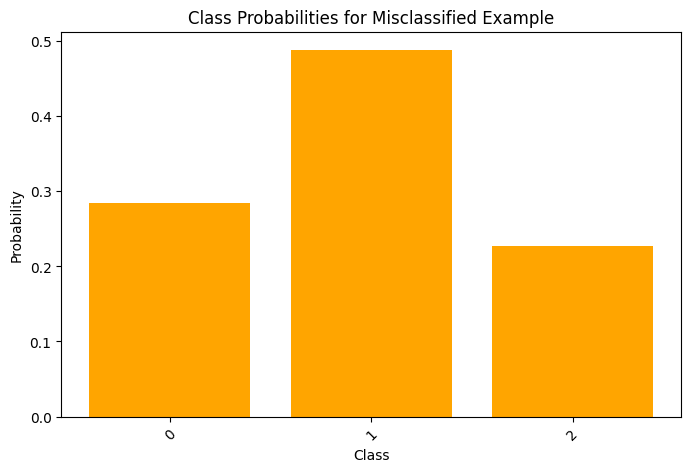

Correct Class Label: 3


In [24]:
import torch
import matplotlib.pyplot as plt

data_iterator = iter(test_loader)
inputs, targets = next(data_iterator)

# Ensure the model is in evaluation mode
model.eval()

# Make predictions on the batch
with torch.no_grad():
    inputs = inputs.float()
    targets = targets.long()

    outputs = model(inputs)
    predicted_classes = torch.argmax(outputs, dim=1)

# Find the first misclassified example
misclassified_indices = (predicted_classes != targets).nonzero(as_tuple=False)
misclassified_index = misclassified_indices[0].item()  # Get the first misclassified example

# Get the class probabilities
class_probabilities = torch.softmax(outputs[misclassified_index], dim=0)

# Get the correct class label
correct_label = targets[misclassified_index].item()

# Convert class probabilities and correct label to numpy arrays
class_probabilities = class_probabilities.numpy()
correct_label = correct_label

# Define a color for the bar chart (e.g., 'orange')
bar_color = 'orange'

# Plot the class probabilities in a bar chart with the specified color
num_classes = len(class_probabilities)
classes = range(num_classes)
plt.figure(figsize=(8, 5))
plt.bar(classes, class_probabilities, tick_label=classes, color=bar_color)
plt.xlabel('Class')
plt.ylabel('Probability')
plt.title('Class Probabilities for Misclassified Example')
plt.xticks(rotation=45)
plt.show()

print(f"Correct Class Label: {correct_label}")


## Task 6: Exploring the patterns in raw data

* Plot the crime incidents as a `scatter` plot using the corrdinates. Use the color property of each datapoint to indicate the day of the week. Is there a pattern in the plot?


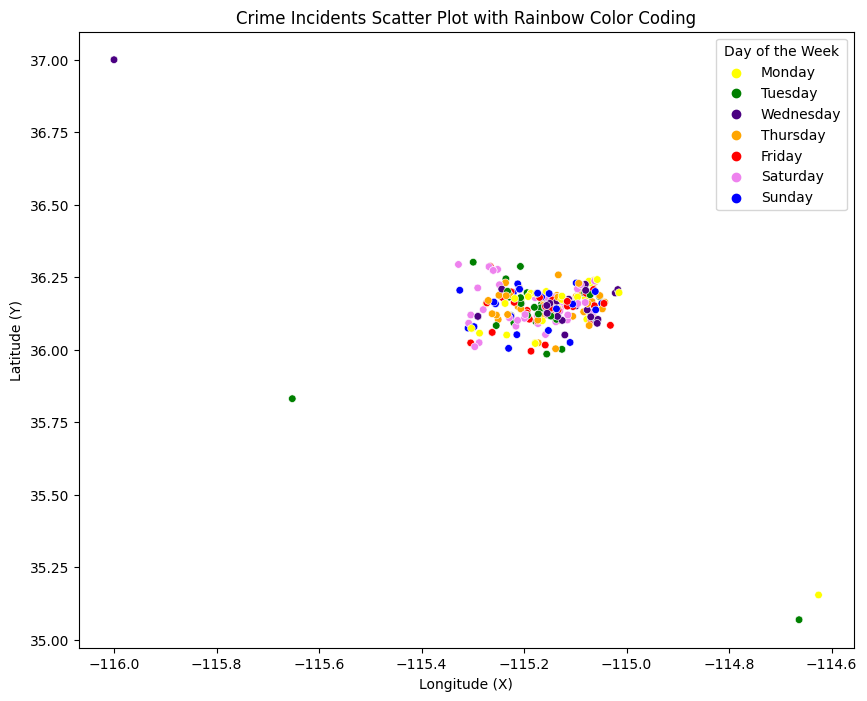

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

day_palette = {
    'Monday': 'violet',
    'Tuesday': 'indigo',
    'Wednesday': 'blue',
    'Thursday': 'green',
    'Friday': 'yellow',
    'Saturday': 'orange',
    'Sunday': 'red'
}

# Create a scatter plot
plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(data=df, x='X', y='Y', hue='DayOfWeek', palette=day_palette, s=30)
plt.title("Crime Incidents Scatter Plot with Rainbow Color Coding")
plt.xlabel("Longitude (X)")
plt.ylabel("Latitude (Y)")

# Customize the legend
handles, labels = scatter.get_legend_handles_labels()
day_labels = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
plt.legend(handles, day_labels, title="Day of the Week")

plt.show()


* Now make a new scatter plot and use the color property of each datapoint to indicate the number of persons involved in the incident. Is there a pattern here?


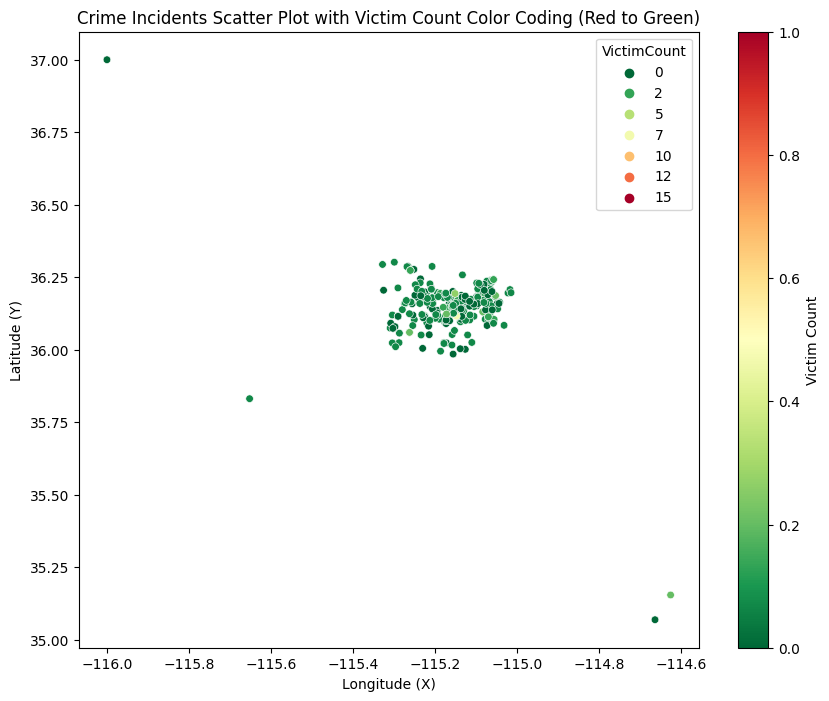

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

colors = sns.color_palette("RdYlGn_r", as_cmap=True)

# Create a scatter plot with color indicating the number of persons involved
plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(data=df, x='X', y='Y', hue='VictimCount', palette=colors, s=30)
plt.title("Crime Incidents Scatter Plot with Victim Count Color Coding (Red to Green)")
plt.xlabel("Longitude (X)")
plt.ylabel("Latitude (Y)")

# Create a colorbar
sm = plt.cm.ScalarMappable(cmap=colors)
sm.set_array([])  # This is needed for the colorbar to work
cbar = plt.colorbar(sm, label="Victim Count", ax=plt.gca())

plt.show()


* use numpy (or pandas if you like) to sort the number of crimes reported by the day of the week. What days are most frequent?

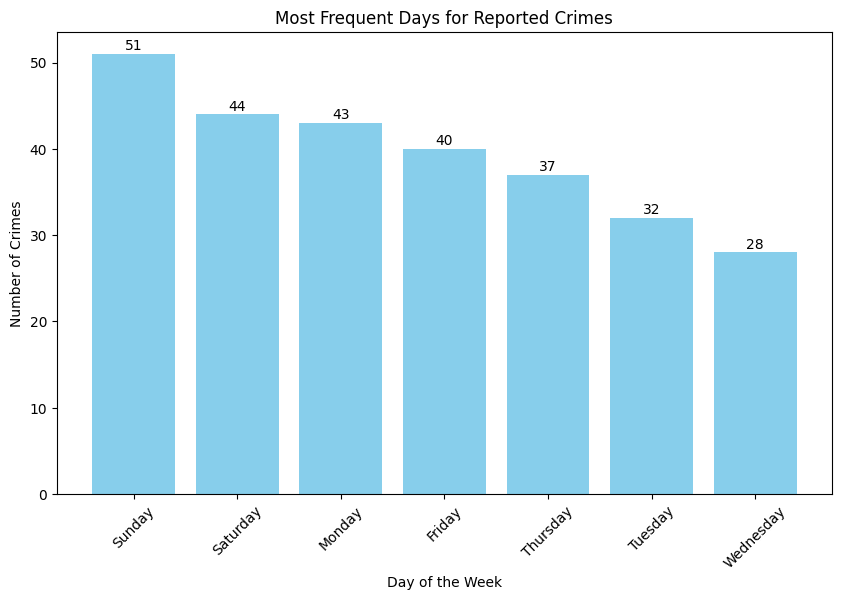

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# Group the data by day of the week and count the number of crimes for each day
day_counts = df['DayOfWeek'].value_counts().reset_index()
day_counts.columns = ['DayOfWeek', 'Count']

# Sort the days by the count of crimes in descending order
sorted_days = day_counts.sort_values(by='Count', ascending=False)

# Create a bar chart with number of crimes printed on top of each bar
plt.figure(figsize=(10, 6))
bars = plt.bar(sorted_days['DayOfWeek'], sorted_days['Count'], color='skyblue')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Crimes')
plt.title('Most Frequent Days for Reported Crimes')
plt.xticks(rotation=45)  # Rotate the day labels for better visibility

# Print the number of crimes on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{int(height)}',  # Convert height to integer for display
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),  # 3 points vertical offset for clean display
                 textcoords="offset points",
                 ha='center')

plt.show()
